In [1]:
import numpy as np
from matplotlib import pyplot as plt
import GPy # import GPy package
import pandas as pd
from timeit import default_timer as timer
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

Y,labels=getOilFlowData()


input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 

Q = input_dim

m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.

start = timer()
m_gplvm.optimize(messages=1, max_iters=1000)
end = timer()
print('Time for GPLVM:'+str(end - start))
m_gplvm.plot_latent(labels)
KNNScore(m_gplvm.latent_mean.values,labels,'GPLVM')


m = GPy.models.bayesian_gplvm_minibatch.BayesianGPLVMMiniBatch(Y, input_dim, num_inducing=30, missing_data=True)
start = timer()
m.optimize(messages=1, max_iters=1000)
end = timer()
print('Time for Bayesian GPLVM:'+str(end - start))
KNNScore(m.latent_space.mean.values,labels,'Bayesian GPLVM')

m_sp = GPy.models.SparseGPLVM(Y, input_dim, kernel=kernel, num_inducing=30)
# m_sp=GPy.models.SparseGPLVM(Y, input_dim, kernel=kernel,num_inducing=30,init='PCA')
from timeit import default_timer as timer
start = timer()
m_sp.optimize(messages=1, max_iters=1000)
end = timer()
print('Time for Sparse GPLVM:'+str(end - start))
KNNScore(m_sp.latent_space.values,labels,'Sparse GPLVM')

##https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/MagnificationFactor.ipynb


Time for GPLVM:314.7014735
GPLVM,Accuracy Score:0.9848484848484849


Time for Bayesian GPLVM:119.3392882
Bayesian GPLVM,Accuracy Score:0.9757575757575757


Time for Sparse GPLVM:32.60307110000002
Sparse GPLVM,Accuracy Score:0.9424242424242424


In [2]:
m_gplvm.likelihood

Gaussian_noise.,value,constraints,priors
variance,0.0019602665084459546,+ve,


In [3]:
m.likelihood

Gaussian_noise.,value,constraints,priors
variance,0.005108493284872931,+ve,


In [4]:
m_sp.likelihood

Gaussian_noise.,value,constraints,priors
variance,0.003924824470631462,+ve,


In [5]:
m.param_array

array([-0.32338415,  0.30023388,  0.48183529, ...,  2.18199274,
        0.52002923,  0.00510849])

In [6]:
m.parameter_names

<bound method OptimizationHandlable.parameter_names of <GPy.models.bayesian_gplvm_minibatch.BayesianGPLVMMiniBatch object at 0x0000012E798BFD48>>

In [7]:
m.latent_space()

TypeError: 'NormalPosterior' object is not callable

In [8]:
m.latent_space(labels)

TypeError: 'NormalPosterior' object is not callable

{'scatter': [<matplotlib.collections.PathCollection at 0x12e03046fc8>],
 'imshow': <matplotlib.image.AxesImage at 0x12e03069ac8>}

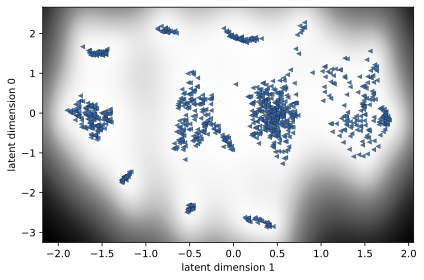

In [9]:
m.plot_latent()

{'scatter': [<matplotlib.collections.PathCollection at 0x12e0ad589c8>,
 'imshow': <matplotlib.image.AxesImage at 0x12e0ad58908>}

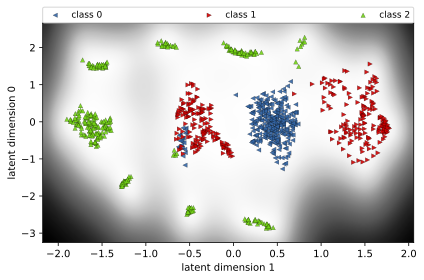

In [10]:
m.plot_latent(labels)

{'scatter': [<matplotlib.collections.PathCollection at 0x12e0ae28608>,
 'imshow': <matplotlib.image.AxesImage at 0x12e0ae236c8>}

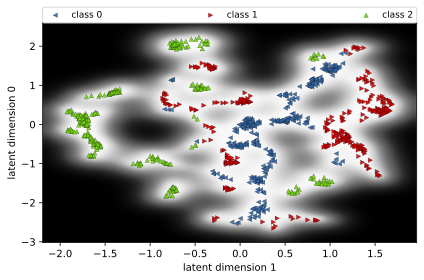

In [11]:
m_gplvm.plot_latent(labels)

In [12]:
m_sp.plot_latent(labels)

ImportError: cannot import name 'dim_reduction_plots' from 'GPy.plotting.matplot_dep' (C:\Users\aniru\AppData\Local\Programs\Python\Python37\lib\site-packages\GPy\plotting\matplot_dep\__init__.py)

In [13]:
def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    # plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()


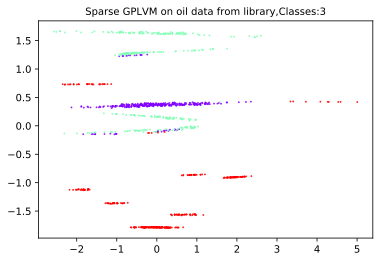

In [14]:
plot2D(m_sp.latent_space.values,labels,'Sparse GPLVM on oil data from library')

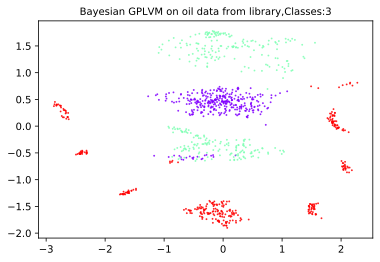

In [15]:
plot2D(m.latent_space.mean.values,labels,'Bayesian GPLVM on oil data from library')

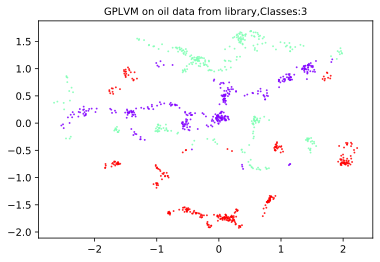

In [16]:
plot2D(m_gplvm.latent_mean.values,labels,'GPLVM on oil data from library')